In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pickle

from tqdm.notebook import tqdm
from datetime import timedelta
#from utils import baseline_SCr

if os.getcwd()[-4:] == "code":
    os.chdir('../')

icu  = './data/mimic-iv-2.2-parquet/icu/'
hosp = './data/mimic-iv-2.2-parquet/hosp/'
ed   = './data/mimic-iv-2.2-parquet/ed/'

In [2]:
labevents     = pd.read_parquet(hosp+'labevents.parquet')
d_labitems    = pd.read_parquet(hosp+'d_labitems.parquet')

patients      = pd.read_parquet(hosp+'patients.parquet')
admissions    = pd.read_parquet(hosp+'admissions.parquet')

diagnoses_icd = pd.read_parquet(hosp+'diagnoses_icd.parquet')
microbiology  = pd.read_parquet(hosp+'microbiologyevents.parquet')
prescriptions = pd.read_parquet(hosp+'prescriptions.parquet')

In [3]:
chartevents     = pd.read_parquet(icu+'chartevents.parquet')
d_items         = pd.read_parquet(icu+'d_items.parquet')
inputevents     = pd.read_parquet(icu+'inputevents.parquet')
outputevents    = pd.read_parquet(icu+'outputevents.parquet')
procedureevents = pd.read_parquet(icu+'procedureevents.parquet')
icustays        = pd.read_parquet(icu+'icustays.parquet')
outputevents    = pd.read_parquet(icu+'outputevents.parquet')

In [4]:
omr = pd.read_parquet(hosp+'omr.parquet')

In [5]:
vitalsign = pd.read_parquet(ed+'vitalsign.parquet')

In [6]:
# to_datetime
chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])

In [7]:
labvalues = pd.read_csv('./data/labvalues/labvalues.csv')
vitals = pd.read_csv('./data/vitals/vitals.csv')

# Demographic

### Gender

In [77]:
patients_gender = patients[['subject_id','gender']]
patients_gender.loc[patients_gender.gender == 'F' , 'gender'] = 1
patients_gender.loc[patients_gender.gender == 'M' , 'gender'] = 0

In [78]:
patients_gender

,subject_id,gender
0,10000032,1
1,10000048,1
2,10000068,1
3,10000084,0
4,10000102,1
...,...,...
299707,19999828,1
299708,19999829,1
299709,19999840,0
299710,19999914,1


### Age

In [71]:
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

In [72]:
icustays_intime = icustays[['subject_id','hadm_id','stay_id','intime']]
patients_age = patients[['subject_id','anchor_age','anchor_year']]

icustays_age = pd.merge(icustays_intime, patients_age, on = 'subject_id', how = 'left')

In [73]:
icustays_age['anchor_age_delta'] = pd.to_timedelta(icustays_age['anchor_age']*365.25, unit='D')
icustays_age['anchor_year'] = pd.to_datetime(icustays_age['anchor_year'],format="%Y")

icustays_age['delta'] = icustays_age['intime'] - icustays_age['anchor_year']
icustays_age['age'] = ((icustays_age['anchor_age_delta'] + icustays_age['delta'])/365.25).dt.days

icustays_age = icustays_age[['subject_id','hadm_id','stay_id','age']]

In [74]:
icustays_age

,subject_id,hadm_id,stay_id,age
0,10000032,29079034,39553978,52
1,10000980,26913865,39765666,76
2,10001217,24597018,37067082,55
3,10001217,27703517,34592300,55
4,10001725,25563031,31205490,46
...,...,...,...,...
73176,19999442,26785317,32336619,43
73177,19999625,25304202,31070865,82
73178,19999828,25744818,36075953,48
73179,19999840,21033226,38978960,58


### Race

In [81]:
admissions_race = admissions[['subject_id','race']].copy()

In [82]:
admissions_race['race'].replace(['ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE','ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN'],'ASIAN',inplace=True)
admissions_race['race'].replace(['BLACK/AFRICAN AMERICAN','BLACK/AFRICAN','BLACK/CAPE VERDEAN','BLACK/CARIBBEAN ISLAND'],'BLACK',inplace=True)
admissions_race['race'].replace(['HISPANIC/LATINO - CENTRAL AMERICAN','HISPANIC/LATINO - COLUMBIAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - DOMINICAN','HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - HONDURAN','HISPANIC/LATINO - MEXICAN',
                             'HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - SALVADORAN','PORTUGUESE','SOUTH AMERICAN'],'HISPANIC OR LATINO',inplace=True)
admissions_race['race'].replace(['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','AMERICAN INDIAN/ALASKA NATIVE'],'OTHER',inplace=True)
admissions_race['race'].replace(['UNABLE TO OBTAIN','PATIENT DECLINED TO ANSWER'],'UNKNOWN',inplace=True)
admissions_race['race'].replace(['WHITE - BRAZILIAN','WHITE - EASTERN EUROPEAN','WHITE - OTHER EUROPEAN','WHITE - RUSSIAN'],'WHITE',inplace=True)

admissions_race = admissions_race.drop_duplicates()

In [83]:
multiple = admissions_race.subject_id.value_counts().loc[lambda x : x > 1].to_frame()
multiple.reset_index(inplace = True)
multiple = multiple.subject_id.unique()

hosp_race_multiple = admissions_race[admissions_race['subject_id'].isin(multiple)]

sol = []
multi = []
for i in hosp_race_multiple.subject_id.unique() :
    tmp = hosp_race_multiple[hosp_race_multiple['subject_id'] == i]
    if (tmp['race'] == 'UNKNOWN').any() :
        tmp = tmp[tmp['race'] != 'UNKNOWN']
    if len(tmp) <2 :
        sol.append(tmp)
    else : 
        multi.append(tmp)
sol = pd.concat(sol)
multi = pd.concat(multi)

multi['race'] = 'MULTIPLE RACE/ETHNICITY'
multi.drop_duplicates(inplace=True)

admissions_race = admissions_race[~admissions_race['subject_id'].isin(sol.subject_id.unique())]
admissions_race = admissions_race[~admissions_race['subject_id'].isin(multi.subject_id.unique())]

admissions_race = pd.concat([admissions_race,sol,multi])

In [84]:
admissions_race.race.value_counts()

race
WHITE                      120002
BLACK                       23061
HISPANIC OR LATINO          10270
UNKNOWN                      9142
ASIAN                        7470
OTHER                        6998
MULTIPLE RACE/ETHNICITY      3790
Name: count, dtype: int64

## Height

In [18]:
# Height(inch)
chartevents_height_inch = chartevents[chartevents['itemid'].isin([226707])]
chartevents_height_inch = chartevents_height_inch[['subject_id','hadm_id','stay_id','charttime','itemid','valuenum']]
chartevents_height_inch['valuenum'] = (chartevents_height_inch['valuenum']*2.54).round(1)

In [19]:
# Height(cm)
chartevents_height_cm = chartevents[chartevents['itemid'].isin([226730])]
chartevents_height_cm = chartevents_height_cm[['subject_id','hadm_id','stay_id','charttime','itemid','valuenum']]

In [20]:
chartevents_height = pd.concat([chartevents_height_cm,chartevents_height_inch])
chartevents_height['charttime'] = pd.to_datetime(chartevents_height['charttime'])
chartevents_height.sort_values(by=['subject_id','hadm_id','stay_id','charttime'],inplace=True)
chartevents_height = chartevents_height[(chartevents_height['valuenum']>0)&(chartevents_height['valuenum']<240)]

In [21]:
omr_height = omr[omr['result_name'].isin(['Height (Inches)', 'Height'])]
omr_height['result_value'] = omr_height['result_value'].astype('float64')
omr_height['result_value'] = (omr_height['result_value']*2.54).round(1)
omr_height = omr_height[['subject_id','chartdate','result_value']]
omr_height['chartdate'] = pd.to_datetime(omr_height['chartdate'])

C:\Users\DAHS\AppData\Local\Temp\ipykernel_132268\1647886970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_height['result_value'] = omr_height['result_value'].astype('float64')
C:\Users\DAHS\AppData\Local\Temp\ipykernel_132268\1647886970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_height['result_value'] = (omr_height['result_value']*2.54).round(1)


In [22]:
def patients_height(icustays,chartevents_height,omr_height):
    icustays['intime'] = pd.to_datetime(icustays['intime'])
    chartevents_height['charttime'] = pd.to_datetime(chartevents_height['charttime'])
    rt = []
    for subject_id in tqdm(icustays.subject_id.unique()):
        tmp_omr_weight = omr_height[omr_height['subject_id']==subject_id]
        for stay_id in icustays[icustays['subject_id']==subject_id].stay_id.unique():
            icustays_intime = icustays[icustays['stay_id'] == stay_id]['intime'].iloc[0]

            admission_weight = 0

            chartevents_weight_list = chartevents_height[chartevents_height['stay_id']==stay_id]
            chartevents_weight_list = chartevents_weight_list[chartevents_weight_list['charttime'] >= icustays_intime]       
            omr_weight_list = tmp_omr_weight[tmp_omr_weight['chartdate'] <= icustays_intime]
            
            if not chartevents_weight_list.empty:
                admission_weight = chartevents_weight_list['valuenum'].iloc[0]
            elif not omr_weight_list.empty:
                admission_weight = omr_weight_list['result_value'].iloc[-1]
            else : 
                admission_weight = np.nan

            rt.append([subject_id,stay_id,admission_weight])
    rt = pd.DataFrame(rt, columns = ['subject_id','stay_id','valuenum'])
    return rt

admission_height = patients_height(icustays,chartevents_height,omr_height)

  0%|          | 0/50920 [00:00<?, ?it/s]

In [23]:
admission_height.valuenum.isna().sum()

41055

## Weight

In [24]:
#Admission Weight(Kg)
chartevents_weight_kg = chartevents[chartevents['itemid'].isin([226512])]
chartevents_weight_kg = chartevents_weight_kg[['subject_id','hadm_id','stay_id','charttime','valuenum']]

#Admission Weight(lbs.)
chartevents_weight_lbs = chartevents[chartevents['itemid'].isin([226531])]
chartevents_weight_lbs = chartevents_weight_lbs[['subject_id','hadm_id','stay_id','charttime','valuenum']]

chartevents_weight_lbs['valuenum'] = (chartevents_weight_lbs['valuenum'] * 0.453592).round(1)
chartevents_weight = pd.concat([chartevents_weight_kg,chartevents_weight_lbs])
chartevents_weight.sort_values(by=['subject_id','hadm_id','stay_id','charttime'],inplace=True)
chartevents_weight = chartevents_weight[(chartevents_weight['valuenum']>0)&(chartevents_weight['valuenum']<250)]

In [25]:
omr_weight = omr[omr['result_name'].isin(['Weight','Weight (Lbs)'])]
omr_weight['result_value'] = omr_weight['result_value'].astype('float64')
omr_weight['result_value'] = (omr_weight['result_value']*0.453592).round(1)
omr_weight = omr_weight[(omr_weight['result_value']>0)&(omr_weight['result_value']<250)]
omr_weight['chartdate'] = pd.to_datetime(omr_weight['chartdate'])

C:\Users\DAHS\AppData\Local\Temp\ipykernel_132268\886211872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_weight['result_value'] = omr_weight['result_value'].astype('float64')
C:\Users\DAHS\AppData\Local\Temp\ipykernel_132268\886211872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_weight['result_value'] = (omr_weight['result_value']*0.453592).round(1)


In [26]:
omr_weight = omr_weight[['subject_id','chartdate','result_value']]
omr_weight.sort_values(by=['subject_id','chartdate'],inplace=True)

In [27]:
def patients_weight(icustays,chartevents_weight,omr_weight,inputevents):
    icustays['intime'] = pd.to_datetime(icustays['intime'])
    chartevents_weight['charttime'] = pd.to_datetime(chartevents_weight['charttime'])
    inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])
    rt = []
    for subject_id in tqdm(icustays.subject_id.unique()):
        tmp_omr_weight = omr_weight[omr_weight['subject_id']==subject_id]
        for stay_id in icustays[icustays['subject_id']==subject_id].stay_id.unique():
            icustays_intime = icustays[icustays['stay_id'] == stay_id]['intime'].iloc[0]

            admission_weight = 0

            chartevents_weight_list = chartevents_weight[chartevents_weight['stay_id']==stay_id]
            chartevents_weight_list = chartevents_weight_list[chartevents_weight_list['charttime'] >= icustays_intime]       
            omr_weight_list = tmp_omr_weight[tmp_omr_weight['chartdate'] <= icustays_intime]
            inputevents_list = inputevents[inputevents['stay_id']==stay_id]
            inputevents_list = inputevents_list[inputevents_list['starttime']>=icustays_intime].sort_values(by=['subject_id','hadm_id','stay_id','starttime'])

            if not chartevents_weight_list.empty:
                admission_weight = chartevents_weight_list['valuenum'].iloc[0]
            elif not omr_weight_list.empty:
                admission_weight = omr_weight_list['result_value'].iloc[-1]
            elif not inputevents_list.empty:
                admission_weight = inputevents_list['patientweight'].iloc[0]
            else : 
                admission_weight = np.nan

            rt.append([subject_id,stay_id,admission_weight])
    rt = pd.DataFrame(rt, columns = ['subject_id','stay_id','valuenum'])
    return rt

admission_weight = patients_weight(icustays,chartevents_weight,omr_weight,inputevents)

  0%|          | 0/50920 [00:00<?, ?it/s]

In [36]:
len(admission_weight)

73181

In [62]:
admission_weight.valuenum.isna().sum()

193

In [63]:
#admission_weight.to_parquet('./data/admission_weight.parquet')

## Comorbidites

In [131]:
comorbidities = pd.read_csv('./data/comorbidities.csv')

In [133]:
def cal_comorbidities(icustays,comorbidities,diagnoses_icd):
    for i,idx in enumerate(tqdm(comorbidities.abbreviation)):
        icd9 = comorbidities.iloc[i].ICD9
        icd9 = icd9.replace(" ","")
        icd9 = icd9.split(",")
        icd10 = comorbidities.iloc[i].ICD10
        icd10 = icd10.replace(" ","")
        icd10 = icd10.split(",")

        tmp_icd9 = diagnoses_icd[(diagnoses_icd['icd_code'].str.startswith(tuple(icd9)))&(diagnoses_icd['icd_version']==9)]
        tmp_icd10 = diagnoses_icd[(diagnoses_icd['icd_code'].str.startswith(tuple(icd10)))&(diagnoses_icd['icd_version']==10)]

        tmp = pd.concat([tmp_icd9,tmp_icd10])
        tmp[idx] = 1
        tmp = tmp[['subject_id','hadm_id',idx]]
        
        if i == 0 :
            rt = pd.merge(icustays,tmp, on=['subject_id','hadm_id'],how='left')
        else : 
            rt = pd.merge(rt,tmp, on=['subject_id','hadm_id'],how='left')
    rt = rt.fillna(0)
    rt = rt[['subject_id','hadm_id','stay_id']+list(comorbidities.abbreviation)]
    rt.drop_duplicates(inplace=True)
    return rt

como = cal_comorbidities(icustays,comorbidities,diagnoses_icd)

  0%|          | 0/9 [00:00<?, ?it/s]

In [135]:
como[como['CKD']==1]

,subject_id,hadm_id,stay_id,LD,DH,HYP,CKD,MI,DM,VD,CHF,COPD
4,10000980,26913865,39765666,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
15,10002155,20345487,32358465,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
16,10002155,23822395,33685454,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
20,10002155,28994087,31090461,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
31,10002430,26295318,38392119,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
188737,19998330,23151993,31085771,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
188739,19998330,24096838,31199714,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
188741,19998330,24096838,33428243,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
188743,19998330,24492004,32641669,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [34]:
icustays

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588
...,...,...,...,...,...,...,...,...
73176,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
73177,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
73178,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
73179,19999840,21033226,38978960,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


## Baseline SCr

In [91]:
chartevents_SCr = pd.read_parquet('./data/labvalues/chartevents_SCr.parquet')

In [125]:
def baseline_SCr(labevents,icustays,patients_gender,icustays_age,admissions_black) :
    icustays['intime'] = pd.to_datetime(icustays['intime'])

    labevents_SCr = labevents[labevents['itemid'].isin([
    50912, # Creatinine, Blood, Chemistry
    52024, # Creatinine, Whole Blood, Blood, Chemistry
    52546  # Creatinine, Blood, Chemistry
    ])]

    labevents_SCr = labevents_SCr[['subject_id','hadm_id','charttime','valuenum']]
    labevents_SCr['charttime'] = pd.to_datetime(labevents_SCr['charttime'])

    icustays['intime'] = pd.to_datetime(icustays['intime'])

    rt = []

    for subject_id in tqdm(icustays.subject_id.unique()) : 
        tmp_labevents = labevents_SCr[labevents_SCr['subject_id'] == subject_id]
        for stay_id in icustays[icustays['subject_id']==subject_id].stay_id.unique() : 
            hadm_id = icustays[icustays['stay_id'] == stay_id].intime.values[0]
            icustays_intime = icustays[icustays['stay_id'] == stay_id].intime.values[0]
            icustays_intime_7days = icustays_intime - np.timedelta64(7,'D')
            icustays_intime_1yr = icustays_intime - np.timedelta64(365,'D')

            gender = patients_gender[patients_gender['subject_id']==subject_id].gender.values[0]
            age = icustays_age[icustays_age['stay_id']==stay_id].age.values[0]
            black =  admissions_black[admissions_black['subject_id']==subject_id].black.values[0]

            baseline_SCr = 0
            MDRD = 0

            labevents_SCr_list_7days = tmp_labevents[(tmp_labevents['charttime'] < icustays_intime)&(tmp_labevents['charttime'] > icustays_intime_7days)]
            labevents_SCr_list_1yr   = tmp_labevents[(tmp_labevents['charttime'] <= icustays_intime_7days)&(tmp_labevents['charttime'] > icustays_intime_1yr)]

            if not labevents_SCr_list_7days.empty:
                baseline_SCr = labevents_SCr_list_7days['valuenum'].min()
                MDRD = 1
            elif not labevents_SCr_list_1yr.empty:
                baseline_SCr = labevents_SCr_list_1yr['valuenum'].median()
                MDRD = 2
            else: 
                baseline_SCr = (np.exp(5.228/1.154-0.203/1.154*np.log(age)-0.299/1.154*gender+0.192/1.154*black-np.log(75)/1.154)).round(1)
                MDRD = 3


            rt.append([subject_id, hadm_id, stay_id, baseline_SCr, MDRD])

    rt = pd.DataFrame(rt, columns=['subject_id','hadm_id','stay_id','baseline_SCr', 'MDRD'])
    return rt

baseline_SCr = baseline_SCr(labevents,icustays,patients_gender,icustays_age,admissions_black)

  0%|          | 0/50920 [00:00<?, ?it/s]

In [150]:
def baseline_SCr2(labevents,icustays,patients_gender,icustays_age,admissions_black) :
    icustays['intime'] = pd.to_datetime(icustays['intime'])

    labevents_SCr = labevents[labevents['itemid'].isin([
    50912, # Creatinine, Blood, Chemistry
    52024, # Creatinine, Whole Blood, Blood, Chemistry
    52546  # Creatinine, Blood, Chemistry
    ])]

    labevents_SCr = labevents_SCr[['subject_id','hadm_id','charttime','valuenum']]
    labevents_SCr['charttime'] = pd.to_datetime(labevents_SCr['charttime'])

    icustays['intime'] = pd.to_datetime(icustays['intime'])

    rt = []

    for subject_id in tqdm(icustays.subject_id.unique()) : 
        tmp_labevents = labevents_SCr[labevents_SCr['subject_id'] == subject_id]
        for stay_id in icustays[icustays['subject_id']==subject_id].stay_id.unique() : 
            hadm_id = icustays[icustays['stay_id'] == stay_id].intime.values[0]
            icustays_intime = icustays[icustays['stay_id'] == stay_id].intime.values[0]
            icustays_intime_7days = icustays_intime - np.timedelta64(7,'D')
            icustays_intime_1yr = icustays_intime - np.timedelta64(365,'D')

            gender = patients_gender[patients_gender['subject_id']==subject_id].gender.values[0]
            age = icustays_age[icustays_age['stay_id']==stay_id].age.values[0]
            black =  admissions_black[admissions_black['subject_id']==subject_id].black.values[0]

            baseline_SCr = 0
            MDRD = 0

            labevents_SCr_list_7days = tmp_labevents[(tmp_labevents['charttime'] < icustays_intime)&(tmp_labevents['charttime'] > icustays_intime_7days)]
            labevents_SCr_list_1yr   = tmp_labevents[(tmp_labevents['charttime'] <= icustays_intime_7days)&(tmp_labevents['charttime'] > icustays_intime_1yr)]

            if not labevents_SCr_list_1yr.empty:
                baseline_SCr = labevents_SCr_list_1yr['valuenum'].median()
                MDRD = 1
            elif not labevents_SCr_list_7days.empty:
                baseline_SCr = labevents_SCr_list_7days['valuenum'].min()
                MDRD = 2
            else: 
                baseline_SCr = (np.exp(5.228/1.154-0.203/1.154*np.log(age)-0.299/1.154*gender+0.192/1.154*black-np.log(75)/1.154)).round(1)
                MDRD = 3


            rt.append([subject_id, hadm_id, stay_id, baseline_SCr, MDRD])

    rt = pd.DataFrame(rt, columns=['subject_id','hadm_id','stay_id','baseline_SCr', 'MDRD'])
    return rt

baseline_SCr = baseline_SCr2(labevents,icustays,patients_gender,icustays_age,admissions_black)

  0%|          | 0/50920 [00:00<?, ?it/s]

<Axes: >

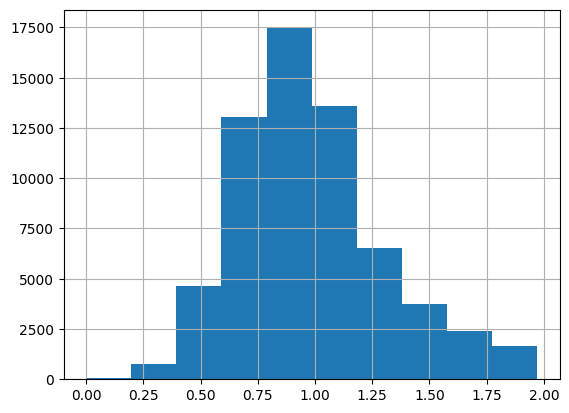

In [138]:
baseline_SCr[baseline_SCr['baseline_SCr']<2].baseline_SCr.hist()

In [156]:
baseline_SCr[baseline_SCr['baseline_SCr']>2].MDRD.value_counts()

MDRD
1    4958
2    2425
Name: count, dtype: int64

In [104]:
icustays[icustays['stay_id']==39553978].intime.values[0]

numpy.datetime64('2180-07-23T14:00:00.000000000')

In [79]:
patients_gender

,subject_id,gender
0,10000032,1
1,10000048,1
2,10000068,1
3,10000084,0
4,10000102,1
...,...,...
299707,19999828,1
299708,19999829,1
299709,19999840,0
299710,19999914,1


In [75]:
icustays_age

,subject_id,hadm_id,stay_id,age
0,10000032,29079034,39553978,52
1,10000980,26913865,39765666,76
2,10001217,24597018,37067082,55
3,10001217,27703517,34592300,55
4,10001725,25563031,31205490,46
...,...,...,...,...
73176,19999442,26785317,32336619,43
73177,19999625,25304202,31070865,82
73178,19999828,25744818,36075953,48
73179,19999840,21033226,38978960,58


In [85]:
admissions_race

,subject_id,race
0,10000032,WHITE
4,10000068,WHITE
5,10000084,WHITE
7,10000108,WHITE
8,10000117,WHITE
...,...,...
430463,19982872,MULTIPLE RACE/ETHNICITY
430476,19982989,MULTIPLE RACE/ETHNICITY
430887,19992507,MULTIPLE RACE/ETHNICITY
431001,19994592,MULTIPLE RACE/ETHNICITY


In [87]:
admissions_black = admissions_race.copy()
admissions_black['black'] = 0
admissions_black.loc[admissions_black['race']=='BLACK','black'] = 1
admissions_black.drop('race',axis=1,inplace=True)

## icustays_with_demo

In [58]:
icustays_with_demo = pd.merge(icustays,patients_gender,on='subject_id',how='left')
icustays_with_demo = pd.merge(icustays_with_demo, icustays_age,on=['subject_id','hadm_id','stay_id'],how='left')
icustays_with_demo = pd.merge(icustays_with_demo, admissions_race,on='subject_id',how='left')
icustays_with_demo = pd.merge(icustays_with_demo, admission_weight,on=['subject_id','stay_id'],how='left')
icustays_with_demo = pd.merge(icustays_with_demo, como,on=['subject_id','hadm_id','stay_id'],how='left')

In [59]:
len(icustays_with_demo)

73181

In [60]:
#icustays_with_demo.to_parquet('./data/icustays_with_demo.parquet')

# Lab values

In [38]:
for i,idx in tqdm(enumerate(labvalues.abbreviation)):
    if not os.path.isfile('./data/labvalues/chartevents_%s.parquet'%idx):
        print("[%i/%i] Processing %s..."%(i+1,len(labvalues),labvalues.iloc[i].labvalue))
        globals()['chartevents_{}'.format(idx)] = chartevents[chartevents['itemid'].isin([labvalues.iloc[i].itemid_icu])][['subject_id','hadm_id','stay_id','charttime','itemid','valuenum']]

        if labvalues.iloc[i].lb_cond == 'ge' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] >= labvalues.iloc[i].lb]
        elif labvalues.iloc[i].lb_cond == 'gt' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] > labvalues.iloc[i].lb]

        if labvalues.iloc[i].ub_cond == 'le' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] <= labvalues.iloc[i].ub]
        elif labvalues.iloc[i].ub_cond == 'lt' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] < labvalues.iloc[i].ub]

        globals()['chartevents_{}'.format(idx)].sort_values(by=['subject_id','charttime'],ascending=True,inplace=True)
        globals()['chartevents_{}'.format(idx)].reset_index(inplace=True, drop=True)
        globals()['chartevents_{}'.format(idx)].to_parquet('./data/labvalues/chartevents_%s.parquet'%idx)
    else : globals()['chartevents_{}'.format(idx)] = pd.read_parquet('./data/labvalues/chartevents_%s.parquet'%idx)

0it [00:00, ?it/s]

In [28]:
for i,idx in tqdm(enumerate(labvalues.abbreviation)):
    try :
        print("[%i/%i] Processing %s..."%(i+1,len(labvalues),labvalues.iloc[i].labvalue))
        itemid = labvalues.iloc[i].itemid_hosp
        if isinstance(itemid, str):
            itemid = itemid.replace(" ","")
            itemid = itemid.split(",")
        if isinstance(itemid, list):
            itemid = [int(x) for x in itemid]
        else : itemid = [int(itemid)]
        globals()['labevents_{}'.format(idx)] = labevents[labevents['itemid'].isin(itemid)][['subject_id','hadm_id','charttime','itemid','valuenum']]

        if labvalues.iloc[i].lb_cond == 'ge' : 
            globals()['labevents_{}'.format(idx)] = globals()['labevents_{}'.format(idx)][globals()['labevents_{}'.format(idx)]['valuenum'] >= labvalues.iloc[i].lb]
        elif labvalues.iloc[i].lb_cond == 'gt' : 
            globals()['labevents_{}'.format(idx)] = globals()['labevents_{}'.format(idx)][globals()['labevents_{}'.format(idx)]['valuenum'] > labvalues.iloc[i].lb]

        if labvalues.iloc[i].ub_cond == 'le' : 
            globals()['labevents_{}'.format(idx)] = globals()['labevents_{}'.format(idx)][globals()['labevents_{}'.format(idx)]['valuenum'] <= labvalues.iloc[i].ub]
        elif labvalues.iloc[i].ub_cond == 'lt' : 
            globals()['labevents_{}'.format(idx)] = globals()['labevents_{}'.format(idx)][globals()['labevents_{}'.format(idx)]['valuenum'] < labvalues.iloc[i].ub]

        globals()['labevents_{}'.format(idx)].sort_values(by=['subject_id','charttime'],ascending=True,inplace=True)
        globals()['labevents_{}'.format(idx)].reset_index(inplace=True, drop=True)

        if not os.path.isfile('./data/labvalues/labevents_%s.parquet'%idx):
            globals()['labevents_{}'.format(idx)].to_parquet('./data/labvalues/labevents_%s.parquet'%idx)
    except: ValueError

0it [00:00, ?it/s]

[1/30] Processing Albumin...
[2/30] Processing Alkaline Phosphate...
[3/30] Processing Anion Gap...
[4/30] Processing Blood urea nitrogen...
[5/30] Processing Calcium non-ionized...
[6/30] Processing Creatine Kinase...
[7/30] Processing Direct Bilirubin...
[8/30] Processing Glucose...
[9/30] Processing Hematocrit...
[10/30] Processing International Normalized Ratio...
[11/30] Processing PH...
[12/30] Processing Phosphorous...
[13/30] Processing Platelet Count...
[14/30] Processing Serum chloride...
[15/30] Processing Serum creatinine...
[16/30] Processing Serum Sodium...
[17/30] Processing Serum Potassium...
[18/30] Processing Total Bilirubin...
[19/30] Processing White blood cell count...
[20/30] Processing Serum glucose...
[21/30] Processing Magnesium...
[22/30] Processing Ionized calcium...
[23/30] Processing Serum HCO3...
[24/30] Processing AST...
[25/30] Processing ALT...
[26/30] Processing PTT...
[27/30] Processing Arterial Base Excess...
[28/30] Processing Lactic Acid...
[29/30]

# Vitals

In [43]:
for i,idx in tqdm(enumerate(vitals.abbreviation)):
    if not os.path.isfile('./data/vitals/chartevents_%s.parquet'%idx):
        print("[%i/%i] Processing %s..."%(i+1,len(vitals),vitals.iloc[i].labvalue))
        itemid = vitals.iloc[i].itemid_icu
        if isinstance(itemid, str):
            itemid = itemid.replace(" ","")
            itemid = itemid.split(",")
        if isinstance(itemid, list):
            itemid = [int(x) for x in itemid]
        else : itemid = [int(itemid)]
        globals()['chartevents_{}'.format(idx)] = chartevents[chartevents['itemid'].isin(itemid)][['subject_id','hadm_id','stay_id','charttime','itemid','valuenum']]

        if vitals.iloc[i].lb_cond == 'ge' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] >= vitals.iloc[i].lb]
        elif vitals.iloc[i].lb_cond == 'gt' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] > vitals.iloc[i].lb]

        if vitals.iloc[i].ub_cond == 'le' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] <= vitals.iloc[i].ub]
        elif vitals.iloc[i].ub_cond == 'lt' : 
            globals()['chartevents_{}'.format(idx)] = globals()['chartevents_{}'.format(idx)][globals()['chartevents_{}'.format(idx)]['valuenum'] < vitals.iloc[i].ub]

        globals()['chartevents_{}'.format(idx)].sort_values(by=['subject_id','charttime'],ascending=True,inplace=True)
        globals()['chartevents_{}'.format(idx)].reset_index(inplace=True, drop=True)
        globals()['chartevents_{}'.format(idx)].to_parquet('./data/vitals/chartevents_%s.parquet'%idx)
    else : globals()['chartevents_{}'.format(idx)] = pd.read_parquet('./data/vitals/chartevents_%s.parquet'%idx)

0it [00:00, ?it/s]

[8/11] Processing Temperature Celsius...
[9/11] Processing Temperature Fahrenheit...


## Temp

In [133]:
chartevents_tempF['valuenum2'] = (chartevents_tempF['valuenum']-32)*5/9
chartevents_tempF.drop('valuenum',axis=1,inplace=True)
chartevents_tempF.rename(columns={'valuenum2':'valuenum'},inplace=True)
chartevents_tempF['valuenum'] = chartevents_tempF['valuenum'].round(1)

chartevents_temp = pd.concat([chartevents_tempC,chartevents_tempF])
chartevents_temp.sort_values(by=['subject_id','hadm_id','stay_id','charttime'],inplace=True)
chartevents_temp.to_parquet('./data/vitals/chartevents_temp.parquet')

# Urine Output

In [58]:
outputevents_uo = outputevents[outputevents['itemid'].isin([
    226557, 226558, #Ureteral Stent, 요관스텐트
    226559, #Foley, 도뇨관(소변줄)
    226560, 226561, 226563, 226564, 226565, 226566, 226567, 226584, 226627, 226631, 226632
])]

guirrigant_input = outputevents[outputevents['itemid'].isin([227488])]
guirrigant_output = outputevents[outputevents['itemid'].isin([227489])]

guirrigant = pd.merge(guirrigant_input,guirrigant_output[['subject_id','hadm_id','stay_id','charttime','value']],on=['subject_id','hadm_id','stay_id','charttime'])
guirrigant['value'] =  guirrigant['value_y'] - guirrigant['value_x']
guirrigant = guirrigant[guirrigant['value'] >= 0]
guirrigant = guirrigant[['subject_id','hadm_id','stay_id','charttime','itemid','value']]

outputevents_uo = outputevents_uo[['subject_id','hadm_id','stay_id','charttime','itemid','value']]
outputevents_uo = pd.concat([outputevents_uo,guirrigant])

outputevents_uo.sort_values(['subject_id','hadm_id','stay_id','charttime'],inplace=True)
outputevents_uo.reset_index(inplace=True,drop=True)

outputevents_uo.to_parquet('./data/others/outputevents_uo.parquet')

# Glasgow Coma Scale

In [74]:
chartevents_GCS_eye = chartevents[chartevents['itemid'].isin([220739])]
chartevents_GCS_verval = chartevents[chartevents['itemid'].isin([223900])]
chartevents_GCS_motor = chartevents[chartevents['itemid'].isin([223901])]

In [128]:
chartevents_GCS_eye.to_parquet('./data/others/chartevents_GCS_eye.parquet')
chartevents_GCS_verval.to_parquet('./data/others/chartevents_GCS_verval.parquet')
chartevents_GCS_motor.to_parquet('./data/others/chartevents_GCS_motor.parquet')

# Fluid/Vasopressor intake

## Fluid

In [31]:
fluid = [220949, 220950, 220952, 225158, 225159, 225161, 225828, 225797, 225799, 225823, 225825, 225827, 225830, 226089, 225941, 225943, 225944, 226361, 226363, 226364, 226375, 226377, 226452, 226453, 227533, 228140, 228141, 228142, 228341, 220955, 220967, 220968, 220953]
inputevents_fluid = inputevents[inputevents['itemid'].isin(fluid)]

In [32]:
inputevents_fluid.amountuom.value_counts()

amountuom
ml      4278391
L            51
cm3           2
nL            1
mm^3          1
pL            1
Name: count, dtype: int64

In [153]:
inputevents_fluid.loc[inputevents_fluid['amountuom']=='L', 'amount'] = inputevents_fluid['amount']*1000
inputevents_fluid.loc[inputevents_fluid['amountuom']=='nL', 'amount'] = 0
inputevents_fluid.loc[inputevents_fluid['amountuom']=='mm^3', 'amount'] = inputevents_fluid['amount']*1e-3
    _fluid.loc[inputevents_fluid['amountuom']=='pL', 'amount'] = inputevents_fluid['amount']*1e-9

In [176]:
from pandas import Timedelta

def calculate_drug_amounts_proportionally(inputevents_,icustays):
    rt = []
    # Select the ICU stay record
    inputevents_['starttime'] = pd.to_datetime(inputevents_['starttime'])
    inputevents_['endtime'] = pd.to_datetime(inputevents_['endtime'])
    icustays['intime'] = pd.to_datetime(icustays['intime'])
    icustays['outtime'] = pd.to_datetime(icustays['outtime'])
    
    for stay_id in tqdm(icustays.stay_id.unique()):
        icu_stay = icustays[icustays['stay_id'] == stay_id]
        tmp_id = icustays[icustays['stay_id']==stay_id][['subject_id','hadm_id','stay_id']].iloc[0].to_list()
        # Create a date range from intime to outtime with 1-hour frequency
        time_range = pd.date_range(start=icu_stay['intime'].iloc[0], end=icu_stay['outtime'].iloc[0], freq='H')

        # Select the drug administration records for this ICU stay
        drug_records = inputevents_[inputevents_['stay_id'] == stay_id]

        # Initialize a DataFrame to store the total drug amount for each hour
        drug_amounts = pd.DataFrame(index=time_range, columns=['valuenum'])
        drug_amounts['valuenum'] = 0

        # Calculate the total drug amount for each hour
        for start, end, amount in zip(drug_records['starttime'], drug_records['endtime'], drug_records['amount']):
            # For each drug record, find the overlapping time with the hourly intervals
            overlap = time_range[(time_range >= start) & (time_range < end)]
            if len(overlap) > 0:
                # Calculate the total duration of drug administration in seconds
                total_duration = (end - start).total_seconds()
                # Calculate the duration of each overlapping hour in seconds
                for hour in overlap:
                    hour_end = hour + Timedelta(hours=1)
                    # Intersection of the drug administration period and the hour
                    intersection_start = max(start, hour)
                    intersection_end = min(end, hour_end)
                    intersection_duration = (intersection_end - intersection_start).total_seconds()
                    # Distribute the drug amount proportionally to the intersection duration
                    proportional_amount = (intersection_duration / total_duration) * amount
                    drug_amounts.loc[hour, 'valuenum'] += proportional_amount
            
        drug_amounts.reset_index(drop=False,inplace=True)
        drug_amounts.rename(columns={'index':'charttime'},inplace=True)
        drug_amounts[['subject_id','hadm_id','stay_id']] = tmp_id
        drug_amounts = drug_amounts[['subject_id','hadm_id','stay_id','charttime','valuenum']]
        rt.append(drug_amounts)
    return pd.concat(rt)

# Test the function with the same sample stay_id
drug_amounts_sample_proportional = calculate_drug_amounts_proportionally(inputevents_fluid,icustays)

C:\Users\DAHS\AppData\Local\Temp\ipykernel_124660\4199976814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputevents_['starttime'] = pd.to_datetime(inputevents_['starttime'])
C:\Users\DAHS\AppData\Local\Temp\ipykernel_124660\4199976814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputevents_['endtime'] = pd.to_datetime(inputevents_['endtime'])


  0%|          | 0/73181 [00:00<?, ?it/s]

In [179]:
inputevents_fluid = drug_amounts_sample_proportional.copy()
inputevents_fluid.to_parquet('./data/others/inptevents_fluid.parquet')

In [33]:
inputevents_fluid = pd.read_parquet('./data/others/inptevents_fluid.parquet')

In [35]:
inputevents_fluid.valuenum.describe()

count    6.099434e+06
mean     3.761108e+01
std      6.571823e+01
min      0.000000e+00
25%      3.000918e+00
50%      1.274385e+01
75%      5.492145e+01
max      2.522840e+04
Name: valuenum, dtype: float64

## Vasopressor

In [8]:
inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])
inputevents['endtime'] = pd.to_datetime(inputevents['endtime'])

In [9]:
inputevents_epinephrine = inputevents[inputevents['itemid'].isin([221289])]
inputevents_dopamine = inputevents[inputevents['itemid'].isin([221662])]
inputevents_dobutamine = inputevents[inputevents['itemid'].isin([221653])]
inputevents_norephinephrine = inputevents[inputevents['itemid'].isin([221906])]
inputevents_phenylephrine = inputevents[inputevents['itemid'].isin([221749, 229630, 229632])]
inputevents_vasopressin = inputevents[inputevents['itemid'].isin([222315])]

In [10]:
# Norephinephrine
inputevents_norephinephrine.loc[inputevents_norephinephrine['rateuom']=='mg/kg/min','rate']= inputevents_norephinephrine['rate']*1e3
inputevents_norephinephrine = inputevents_norephinephrine[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

# Epinephrine
inputevents_epinephrine = inputevents_epinephrine[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

# Phenylephrine
inputevents_phenylephrine.loc[inputevents_phenylephrine['rateuom']=='mcg/min','rate'] = inputevents_phenylephrine['rate']/inputevents_phenylephrine['patientweight']
inputevents_phenylephrine = inputevents_phenylephrine[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

# Vasopressin
inputevents_vasopressin.loc[inputevents_vasopressin['rateuom']=='units/hour', 'rate'] = inputevents_vasopressin['rate']/60
inputevents_vasopressin = inputevents_vasopressin[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

### Dopamine
inputevents_dopamine = inputevents_dopamine[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

# Dobupamine
inputevents_dobutamine = inputevents_dobutamine[['subject_id','hadm_id','stay_id','starttime','endtime','rate']]

In [64]:
def resample_icu_stays_optimized(icustays, inputevents, name):
    resampled_data = []
    # inputevents에 있는 모든 stay_id를 미리 확인
    inputevents_stay_ids = set(inputevents['stay_id'].unique())

    for stay_id in tqdm(icustays.stay_id.unique()):
        intime = icustays[icustays['stay_id']==stay_id].intime.values[0]
        outtime = icustays[icustays['stay_id']==stay_id].outtime.values[0]
        subject_id = icustays[icustays['stay_id']==stay_id].subject_id.values[0]
        hadm_id = icustays[icustays['stay_id']==stay_id].hadm_id.values[0]

        # 1시간 단위로 시간대 생성
        time_range = pd.date_range(start=intime, end=outtime, freq='H')

        # inputevents에 stay_id가 있는지 확인
        if stay_id in inputevents_stay_ids:
            # 해당 stay_id의 inputevents 데이터 필터링
            stay_inputevents = inputevents[inputevents['stay_id'] == stay_id]

            for timestamp in time_range:
                end_time = timestamp + pd.Timedelta(hours=1)

                # 해당 시간대에 해당하는 inputevents의 rate 합계 계산
                rates = stay_inputevents[(stay_inputevents['starttime'] < end_time) & 
                                         (stay_inputevents['endtime'] >= timestamp)]['rate']
                total_rate = rates.sum() if not rates.empty else 0

                resampled_data.append({'subject_id':subject_id,'hadm_id':hadm_id,'stay_id': stay_id, 'charttime': timestamp, name: total_rate})
        else:
            # inputevents에 stay_id가 없는 경우, 모든 rate를 0으로 설정
            for timestamp in time_range:
                resampled_data.append({'subject_id':subject_id,'hadm_id':hadm_id,'stay_id': stay_id, 'charttime': timestamp, name: 0})

    return pd.DataFrame(resampled_data)

# 이 함수는 icustays와 inputevents DataFrame을 입력으로 받습니다.
# 예시:
# resampled_icu_data = resample_icu_stays_optimized(icustays_df, inputevents_df)


In [65]:
Vaso = ['epinephrine','dopamine','dobutamine','norephinephrine','phenylephrine','vasopressin']
for i,idx in enumerate(tqdm(Vaso)):
    globals()['resample_{}'.format(idx)] = resample_icu_stays_optimized(icustays, globals()['inputevents_{}'.format(idx)],idx)
    globals()['resample_{}'.format(idx)].to_parquet('./data/resample/resample_%s.parquet'%idx)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

  0%|          | 0/73181 [00:00<?, ?it/s]

In [58]:
resample_epinephrine.rate.describe()

count    6.099434e+06
mean     1.344034e-03
std      5.619700e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.258903e+01
Name: rate, dtype: float64

# Ventilator

In [141]:
chartevents_CPAP = chartevents[chartevents['itemid'].isin([227583])]
procedureevents_ventilation = procedureevents[procedureevents['itemid'].isin([225792,225794])]

In [157]:
procedureevents_ventilation['rate'] = 1

C:\Users\DAHS\AppData\Local\Temp\ipykernel_184608\2484696807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procedureevents_ventilation['rate'] = 1


In [162]:
procedureevents_ventilation['starttime'] = pd.to_datetime(procedureevents_ventilation['starttime'])
procedureevents_ventilation['endtime'] = pd.to_datetime(procedureevents_ventilation['endtime'])

C:\Users\DAHS\AppData\Local\Temp\ipykernel_184608\1406317010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procedureevents_ventilation['starttime'] = pd.to_datetime(procedureevents_ventilation['starttime'])
C:\Users\DAHS\AppData\Local\Temp\ipykernel_184608\1406317010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procedureevents_ventilation['endtime'] = pd.to_datetime(procedureevents_ventilation['endtime'])


In [163]:
resample_ventilation = resample_icu_stays_optimized(icustays,procedureevents_ventilation,'ventilation')

  0%|          | 0/73181 [00:00<?, ?it/s]